# Conjunctivitis classification with MobileNetV3 (PyTorch)

This notebook trains and evaluates a MobileNetV3 (lightweight) model on a binary conjunctivitis dataset organized as: `Dataset/healthy_eye/` and `Dataset/infected_eye/`.

Requirements: see `../requirements.txt`.

In [1]:
# Install (optional) - run in notebook kernel if needed
!pip install -r ../requirements.txt

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 MB 1.5 MB/s  0:00:54m0:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 1.4 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 685.0 kB/s  0:00:07 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 1.3 MB/s  0:00:06 eta 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 1.8 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 1.2 MB/s  0:00:06m0:00:0100:010m
Using cached tqdm-4.67.

In [2]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Config
DATA_DIR = Path('..') / 'Dataset'
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_CLASSES = 2
NUM_EPOCHS = 12
LR = 1e-3
WEIGHT_DECAY = 1e-4
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('device:', DEVICE)
print('data dir exists:', DATA_DIR.exists())

device: cpu
data dir exists: True


In [4]:
# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [5]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

In [6]:
# Use torchvision.datasets.ImageFolder and create a train/val split
full_dataset = datasets.ImageFolder(root=str(DATA_DIR), transform=train_transform)
class_names = full_dataset.classes
print('classes:', class_names)

# split 80/20
n = len(full_dataset)
n_val = int(0.2 * n)
n_train = n - n_val
train_ds, val_ds = random_split(full_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))

# Ensure val uses val_transform rather than train augmentation
# random_split returns Subset objects; wrap val subset into a new dataset with val_transform
from torch.utils.data import Subset
val_ds = Subset(datasets.ImageFolder(root=str(DATA_DIR), transform=val_transform), val_ds.indices)

print(f'train images: {len(train_ds)}, val images: {len(val_ds)}')

classes: ['healthy_eye', 'infected_eye']
train images: 287, val images: 71


/Users/noormustafa/Documents/GitHub/disease_detection/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:1118: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


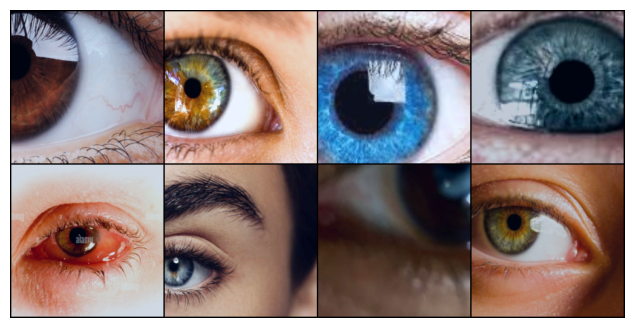

In [7]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# quick visual check
import torchvision.utils as vutils
batch = next(iter(train_loader))
images, labels = batch
grid = vutils.make_grid(images[:8], nrow=4, normalize=True)
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
plt.axis('off')
plt.show()

In [13]:
# Build model: MobileNetV3 small (lightweight)
model = models.mobilenet_v3_small(pretrained=True)
# Determine the correct number of input features for the classifier's Linear layer
in_features = None
# The classifier usually starts with a Linear that consumes the pooled features — find the first Linear
for m in model.classifier:
    if isinstance(m, nn.Linear):
        in_features = m.in_features
        break
if in_features is None:
    # fallback: try the first module
    try:
        in_features = model.classifier[0].in_features
    except Exception:
        raise RuntimeError('Could not determine classifier in_features for MobileNetV3')
# Replace classifier for binary classification using the detected feature size
model.classifier = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, NUM_CLASSES)
)
model = model.to(DEVICE)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [14]:
# Training loop with validation and best-model saving
best_val_acc = 0.0
save_path = Path('..') / 'models'
save_path.mkdir(exist_ok=True)
best_model_file = save_path / 'mobilenetv3_best.pth'

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{NUM_EPOCHS} - train')
    for inputs, targets in pbar:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == targets).sum().item()
        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects / len(train_loader.dataset)

    # validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            preds = outputs.argmax(dim=1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += (preds == targets).sum().item()
            all_preds.extend(preds.cpu().numpy().tolist())
            all_targets.extend(targets.cpu().numpy().tolist())

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_corrects / len(val_loader.dataset)

    print(f'Epoch {epoch}: train_loss={epoch_loss:.4f} train_acc={epoch_acc:.4f} val_loss={val_loss:.4f} val_acc={val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({'model_state_dict': model.state_dict(), 'class_names': class_names}, best_model_file)
        print('Saved best model to', best_model_file)

    scheduler.step()

Epoch 1/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.72s/it, loss=0.266]


Epoch 1: train_loss=0.4928 train_acc=0.7526 val_loss=0.3210 val_acc=0.8310
Saved best model to ../models/mobilenetv3_best.pth


Epoch 2/12 - train: 100%|██████████| 9/9 [00:43<00:00,  4.78s/it, loss=0.179]


Epoch 2: train_loss=0.2351 train_acc=0.9059 val_loss=0.0312 val_acc=1.0000
Saved best model to ../models/mobilenetv3_best.pth


Epoch 3/12 - train: 100%|██████████| 9/9 [00:44<00:00,  4.89s/it, loss=0.345] 


Epoch 3: train_loss=0.1524 train_acc=0.9477 val_loss=0.1551 val_acc=0.9437


Epoch 4/12 - train: 100%|██████████| 9/9 [00:43<00:00,  4.88s/it, loss=0.111] 


Epoch 4: train_loss=0.1176 train_acc=0.9582 val_loss=0.0039 val_acc=1.0000


Epoch 5/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.70s/it, loss=0.467] 


Epoch 5: train_loss=0.1567 train_acc=0.9408 val_loss=0.0020 val_acc=1.0000


Epoch 6/12 - train: 100%|██████████| 9/9 [00:41<00:00,  4.65s/it, loss=0.0183]


Epoch 6: train_loss=0.1200 train_acc=0.9443 val_loss=0.0021 val_acc=1.0000


Epoch 7/12 - train: 100%|██████████| 9/9 [00:41<00:00,  4.63s/it, loss=0.07]  


Epoch 7: train_loss=0.0415 train_acc=0.9895 val_loss=0.0023 val_acc=1.0000


Epoch 8/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.76s/it, loss=0.0534]


Epoch 8: train_loss=0.0693 train_acc=0.9617 val_loss=0.0026 val_acc=1.0000


Epoch 9/12 - train: 100%|██████████| 9/9 [00:42<00:00,  4.75s/it, loss=0.157] 


Epoch 9: train_loss=0.0638 train_acc=0.9791 val_loss=0.0036 val_acc=1.0000


Epoch 10/12 - train: 100%|██████████| 9/9 [00:46<00:00,  5.15s/it, loss=0.0608]


Epoch 10: train_loss=0.0644 train_acc=0.9791 val_loss=0.0039 val_acc=1.0000


Epoch 11/12 - train: 100%|██████████| 9/9 [00:46<00:00,  5.17s/it, loss=0.104] 


Epoch 11: train_loss=0.0916 train_acc=0.9686 val_loss=0.0046 val_acc=1.0000


Epoch 12/12 - train: 100%|██████████| 9/9 [00:44<00:00,  4.95s/it, loss=0.014] 


Epoch 12: train_loss=0.0509 train_acc=0.9895 val_loss=0.0053 val_acc=1.0000


Classification Report:
              precision    recall  f1-score   support

 healthy_eye       1.00      1.00      1.00        34
infected_eye       1.00      1.00      1.00        37

    accuracy                           1.00        71
   macro avg       1.00      1.00      1.00        71
weighted avg       1.00      1.00      1.00        71



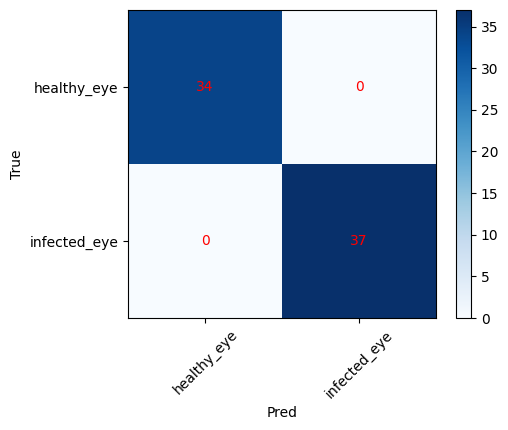

In [15]:
# Load best model and evaluate in detail
checkpoint = torch.load(best_model_file, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE)
model.eval()

all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_targets.extend(targets.cpu().numpy().tolist())

print('Classification Report:')
print(classification_report(all_targets, all_preds, target_names=class_names))

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.xticks([0,1], class_names, rotation=45)
plt.yticks([0,1], class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='red')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Pred')
plt.show()

In [16]:
# Inference helper
from PIL import Image
def predict_image(img_path, model, transform, class_names):
    img = Image.open(img_path).convert('RGB')
    x = transform(img).unsqueeze(0).to(DEVICE)
    model.eval()
    with torch.no_grad():
        out = model(x)
        p = torch.softmax(out, dim=1)
        conf, pred = torch.max(p, dim=1)
    return class_names[pred.item()], conf.item()

# Example usage (update path to an example image)
# example_img = '../Dataset/infected_eye/some_image.jpg'
# print(predict_image(example_img, model, val_transform, class_names))

## Notes and next steps
- Tune learning rate, batch size, augmentations.
- Consider transfer learning freezes: initially freeze backbone features and train classifier, then unfreeze.
- For small datasets, use stronger augmentation and possibly k-fold cross-validation.
- If you need an object-detection approach (localizing signs), consider a YOLOv8 workflow instead.